In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
import face_detector as fd
import cv2
import numpy as np
import csv

#CONFIGURATION

OUT_DIR = "no_segmentation/"
#OUT_DIR = "with_segmentation/"
MODEL_PATH = OUT_DIR + "model.out"
WEIGHTS_PATH = OUT_DIR + "output/073.epoch"
LABELS_PATH = "names_10.txt"
DATA_DIR = "data"
segmentation = False

def get_labels():
    label_map = {}
    dataset_labels = []
    with open(LABELS_PATH) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            label_map[int(row[2])] = row[1]
        for i in range(0, len(label_map)):
            dataset_labels.append(label_map[i])
    return dataset_labels

labels = get_labels()

In [3]:
#this may take a few minutes, calculates mean and std of training set to normalize data before prediction

from os import listdir
from os.path import isfile, join

def get_dir2labels():
    dataset_labels = {}
    with open(LABELS_PATH) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            dataset_labels[row[0]] = row[1]
    return dataset_labels

def load_images(subdir, segmentation = False):
    dataset_labels = get_dir2labels()
    folder_list = list(dataset_labels.keys())
    images = []
    labels = []
    for dir in folder_list:
        current_path = DATA_DIR +  "/" + dir + "/" + subdir + "/"
        onlyfiles = [f for f in listdir(current_path) if isfile(join(current_path, f))]
        for i in range(0, len(onlyfiles)):
            coords, faces = fd.get_faces_from_img_path(current_path + onlyfiles[i], segmentation)
            for j in range(0, len(faces)):
                images.append(faces[j])
                labels.append(dataset_labels[dir])
    return images, labels

train_data,train_labels = load_images("train", segmentation)
mean = np.mean(train_data, axis = 0)
std = np.std(train_data, axis = 0)

In [4]:
def load_model(modelPath, weightsPath):
    model = tf.keras.models.load_model(modelPath)
    model.load_weights(weightsPath)
    return model

model = load_model(MODEL_PATH, WEIGHTS_PATH)

def predict(model, faces):    
    predictionsRaw = model.predict(faces)
    predictions = predictionsRaw.argmax(axis=-1)
    predictions2labels = []
    for i in range(0, len(predictions)):
        predictions2labels.append({labels[predictions[i]] : round(predictionsRaw[i][predictions[i]],2)})
    return predictions2labels

{'Helen_Hunt': 1.0}


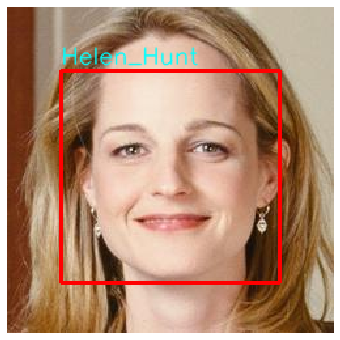

In [5]:
imgPath = "data/0000166/test/059.jpg"
#imgPath = "data/0000169/test/172.jpg"
#imgPath = "data/0000099/test/014.jpg"

coords, faces = fd.get_faces_from_img_path(imgPath, segmentation)
faces = (faces - mean) / std
predictions = []
if len(faces) > 0:
    predictions = predict(model, np.array(faces))
else:
    print("found no face to predict")
    
image = cv2.imread(imgPath, 1)

for i, face in enumerate(faces):
    x, y, w, h = coords[i]
    cv2.rectangle(image, (x, y+5), (x+w, y+h), (0,0,255), 2)
    
    cv2.putText(image, list(predictions[i].keys())[0], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 1, cv2.LINE_AA) 
    
    print(predictions[i])
    
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

face without segmentation


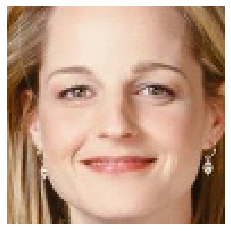

face segmentation


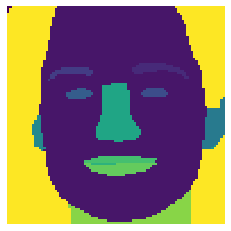

face after segmentation


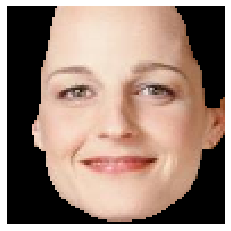

In [8]:
#This is just to showcase how was the segmentation done

from face_toolbox_keras.utils.visualize import show_parsing_with_annos
from face_toolbox_keras.models.parser import face_parser
imgPath = "data/0000166/test/059.jpg"
im = cv2.imread(imgPath, 1)
parser = face_parser.FaceParser()

coords, faces = fd.get_faces_from_img_path(imgPath, useSegmentation=False)

print("face without segmentation")

for face in faces:
    plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
    plt.axis("off")

plt.show()

print("face segmentation")

for face in faces:
    segments = parser.parse_face(face)
    plt.imshow(segments[0])
    plt.axis("off")
    
plt.show()

coords, faces = fd.get_faces_from_img_path(imgPath, useSegmentation=True)

print("face after segmentation")

for face in faces:
    plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
    plt.axis("off")

plt.show()

In [6]:
#calculates model accuracy on all test data
def test_model():
    dataset_labels = get_dir2labels()
    folder_list = list(dataset_labels.keys())
    correct = 0
    total = 0
    for dir in folder_list:
        current_path = DATA_DIR + "/" + dir + "/test/"
        onlyfiles = [f for f in listdir(current_path) if isfile(join(current_path, f))]
        for i in range(0, len(onlyfiles)):
            coords, faces = fd.get_faces_from_img_path(current_path + onlyfiles[i], segmentation)
            for j in range(0, len(faces)):
                faces = (faces - mean) / std
                predictions = predict(model, np.array(faces))
                if list(predictions[j].keys())[0] == dataset_labels[dir]:
                    correct += 1
                total += 1
    return correct/total

acc = test_model()
print("models accuracy on all test data = ", acc)

models accuracy on all test data =  0.8178438661710037
